In [1]:
# Importar librerías
import io
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import seaborn as sns
from sklearn import preprocessing



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Leo el arcivo Local
uploaded = files.upload()

Saving baterias-datos.csv to baterias-datos.csv


**a.	Lectura y descripción rápida de los datos.**

Vamos a Utilizar la metodología Crisp DM:

1. Entender el negocio
2. Entender los datos, que variables tengo, que variables me sirven
3. Procesar los datos, eliminar outliers, tratamiento de Nulos
4. Elegir y desarrollar el modelo 
5. Colocar el modelo en producción (no aplica en este caso)

In [3]:
#se carga el archivo de excel
archivo = io.BytesIO(uploaded['Base modelo.xlsx'])
df = pd.read_excel(archivo)


KeyError: ignored

**Análisis exploratorio de datos**

In [ ]:
df.head()
# Se examina el encabezado para comprobar la correcta visualización de los datos

,REGIONAL,DEPARTAMENTO,TECNOL,GERENCIA,CANAL_HOMOLOGADO_MILLICON,tipo_fuerza_venta,estrato,antiguedad_meses,productos,portafolio,no_serv_tecnicos,fallo,asesoria_factura,pedidos_peticiones,reagendamiento,asesoria_servicios,retencion,Otras,quejas_fraude,traslado,Incumplimiento_pago,cliente_id
0,COSTA,MAGDALENA,HFC,CONTACT,SAC,INDIRECTA,3,19.0,TV+BA,Duo,1.0,No funciona línea telefónica,0,0,0,0,0,0,0,0,0,1004369760
1,COSTA,MAGDALENA,HFC,CONTACT,SAC,INDIRECTA,3,19.0,TV+BA,Duo,1.0,No funciona línea telefónica,0,0,0,0,0,0,0,0,0,1004369760
2,NOROCCIDENTE,ANTIOQUIA,HFC,CONTACT,SAC,INDIRECTA,1,1.0,TV,Individual,1.0,No navega,0,0,0,0,0,0,0,0,0,1004371304
3,COSTA,MAGDALENA,HFC,CONTACT,IN BOUND,INDIRECTA,3,7.0,TO+TV+BA,Trio,NaN,NaN,0,0,0,0,0,0,0,0,1,1004382867
4,COSTA,MAGDALENA,HFC,CONTACT,IN BOUND,INDIRECTA,3,7.0,TO+TV+BA,Trio,NaN,NaN,0,0,0,0,0,0,0,0,1,1004382867


Se puede detectar que la variable target (o predictoria) es Incumplimiento_Pago

In [ ]:
#vemos el tipo de varaiabes del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19942 entries, 0 to 19941
Data columns (total 22 columns):
REGIONAL                     19942 non-null object
DEPARTAMENTO                 19942 non-null object
TECNOL                       19942 non-null object
GERENCIA                     19942 non-null object
CANAL_HOMOLOGADO_MILLICON    19942 non-null object
tipo_fuerza_venta            19942 non-null object
estrato                      19942 non-null object
antiguedad_meses             18264 non-null float64
productos                    19942 non-null object
portafolio                   19942 non-null object
no_serv_tecnicos             6909 non-null float64
fallo                        6909 non-null object
asesoria_factura             19942 non-null int64
pedidos_peticiones           19942 non-null int64
reagendamiento               19942 non-null int64
asesoria_servicios           19942 non-null int64
retencion                    19942 non-null int64
Otras                        

In [ ]:
#Cuantos Nulos hay
df.isnull().sum()/len(df)*100

REGIONAL                      0.000000
DEPARTAMENTO                  0.000000
TECNOL                        0.000000
GERENCIA                      0.000000
CANAL_HOMOLOGADO_MILLICON     0.000000
tipo_fuerza_venta             0.000000
estrato                       0.000000
antiguedad_meses              8.414402
productos                     0.000000
portafolio                    0.000000
no_serv_tecnicos             65.354528
fallo                        65.354528
asesoria_factura              0.000000
pedidos_peticiones            0.000000
reagendamiento                0.000000
asesoria_servicios            0.000000
retencion                     0.000000
Otras                         0.000000
quejas_fraude                 0.000000
traslado                      0.000000
Incumplimiento_pago           0.000000
cliente_id                    0.000000
dtype: float64

hay valores Nulos en el set de datos, en las variables no_serv_tecnicos y fallo con un porcentaje del 65 % al ser tan alto es inapropiado la imputación de datos, por lo tanto se toma la decisión de eliminar ambas variables

In [ ]:
pd.options.display.float_format = "{:.2f}".format
df.describe(include='all')

,REGIONAL,DEPARTAMENTO,TECNOL,GERENCIA,CANAL_HOMOLOGADO_MILLICON,tipo_fuerza_venta,estrato,antiguedad_meses,productos,portafolio,no_serv_tecnicos,fallo,asesoria_factura,pedidos_peticiones,reagendamiento,asesoria_servicios,retencion,Otras,quejas_fraude,traslado,Incumplimiento_pago,cliente_id
count,19942,19942,19942,19942,19942,19942,19942.00,18264.00,19942,19942,6909.00,6909,19942.00,19942.00,19942.00,19942.00,19942.00,19942.00,19942.00,19942.00,19942.00,19942.00
unique,6,22,4,6,11,2,7.00,nan,7,3,nan,20,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,NOROCCIDENTE,ANTIOQUIA,HFC,CONTACT,SAC,INDIRECTA,2.00,nan,TO+TV+BA,Trio,nan,No navega,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,11640,11655,15628,10075,4768,18893,6413.00,nan,7933,7933,nan,2845,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,NaN,nan,43.14,NaN,NaN,1.00,NaN,0.06,0.05,0.02,0.03,0.01,0.01,0.03,0.05,0.14,412440229.47
std,NaN,NaN,NaN,NaN,NaN,NaN,nan,60.38,NaN,NaN,0.00,NaN,0.23,0.22,0.15,0.16,0.12,0.08,0.16,0.21,0.35,499318217.50
min,NaN,NaN,NaN,NaN,NaN,NaN,nan,0.00,NaN,NaN,1.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,39787.00
25%,NaN,NaN,NaN,NaN,NaN,NaN,nan,4.00,NaN,NaN,1.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,32259580.75
50%,NaN,NaN,NaN,NaN,NaN,NaN,nan,16.00,NaN,NaN,1.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,66975106.00
75%,NaN,NaN,NaN,NaN,NaN,NaN,nan,52.00,NaN,NaN,1.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1036623045.50



Hay un total de 19.942 registros, no se detectan valores atípicos, aunque en la antiguedad_meses hay un valor maximo de 337 meses (28 años), no hay conocimiento suficiente para decir q es un valor atípico, por lo tanto no se elimina el registro.

Se evidencia que más del 80% del tipo_fuerza_venta es de manera indirecta

Se analiza que los datos contiene las variables regional y departamento, estás variables están altamente correlacionadas, por lo tanto se deja el que más detalle brinde en esté caso se deja el departamento y se elimina la variable de regional.


In [ ]:
#Variable objetivo, el 1 indica que el cliente no pago la primera factura
# Se verifica como esta distribuida la variable target
df['Incumplimiento_pago'].value_counts()

0    17087
1     2855
Name: Incumplimiento_pago, dtype: int64

Se evidencia que la variable está desbalanceada, es decir hay muchos más 0 que 1, y nuestro objetivo es analizar los clientes que no pagaron la primera factura es decir el 1, por lo tanto se hace necesario balancear las muestras con un remuestreo.

In [ ]:
#Si la variable asume el valor de 1 es que el cliente llamo a pedir una asesoría en factura
df['asesoria_factura'].value_counts()

0    18814
1     1128
Name: asesoria_factura, dtype: int64

In [ ]:
#Si la variable asume el valor de 1 es que el cliente llamo a hacer una petición queja o reclamo
df['pedidos_peticiones'].value_counts()

0    18908
1     1034
Name: pedidos_peticiones, dtype: int64

In [ ]:
#Si la variable asume el valor de 1 es que el cliente llamo a reagendar un servicio
df['reagendamiento'].value_counts()


0    19493
1      449
Name: reagendamiento, dtype: int64

In [ ]:
#Si la variable asume el valor de 1 es que el cliente llamo a pedir una asesoría en el uso del servicio
df['asesoria_servicios'].value_counts()


0    19424
1      518
Name: asesoria_servicios, dtype: int64

In [ ]:
#Si la variable asume el valor de 1 es que el cliente llamo a cancelar voluntariamente el servicio
df['retencion'].value_counts()

0    19669
1      273
Name: retencion, dtype: int64

In [ ]:
#Si la variable asume el valor de 1 es que el cliente llamo por otros motivos
df['Otras'].value_counts()

0    19819
1      123
Name: Otras, dtype: int64

In [ ]:
#El cliente presentó una queja de posible fraude por suplantación de identidad
df['quejas_fraude'].value_counts()


0    19433
1      509
Name: quejas_fraude, dtype: int64

In [ ]:
#El cliente solicitó un traslado del servicio
df['traslado'].value_counts()


0    18980
1      962
Name: traslado, dtype: int64

**Procesamiento de Datos**

Se eliminan las variables que no aportan al moelo

In [ ]:
df_mod=df.drop(['no_serv_tecnicos','fallo','REGIONAL','cliente_id'],axis=1).copy()

In [ ]:
#Cuantos Nulos hay
df_mod.isnull().sum()/len(df)*100

DEPARTAMENTO                0.00
TECNOL                      0.00
GERENCIA                    0.00
CANAL_HOMOLOGADO_MILLICON   0.00
tipo_fuerza_venta           0.00
estrato                     0.00
antiguedad_meses            8.41
productos                   0.00
portafolio                  0.00
asesoria_factura            0.00
pedidos_peticiones          0.00
reagendamiento              0.00
asesoria_servicios          0.00
retencion                   0.00
Otras                       0.00
quejas_fraude               0.00
traslado                    0.00
Incumplimiento_pago         0.00
dtype: float64

Vamos a imputar los datos nulos de la variable antiguedad_meses, se hace con la mediana, ya que el promedio es sensible a valores extremos


In [ ]:
df_mod['antiguedad_meses']=df_mod['antiguedad_meses'].fillna(df_mod.antiguedad_meses.median())

In [ ]:
#Cuantos Nulos hay
df_mod.isnull().sum()/len(df)*100

DEPARTAMENTO                0.00
TECNOL                      0.00
GERENCIA                    0.00
CANAL_HOMOLOGADO_MILLICON   0.00
tipo_fuerza_venta           0.00
estrato                     0.00
antiguedad_meses            0.00
productos                   0.00
portafolio                  0.00
asesoria_factura            0.00
pedidos_peticiones          0.00
reagendamiento              0.00
asesoria_servicios          0.00
retencion                   0.00
Otras                       0.00
quejas_fraude               0.00
traslado                    0.00
Incumplimiento_pago         0.00
dtype: float64

Se verifica que en el dataset no hay valores nulos, pero la variable estrato tiene SE (Sin Estrato) el cuál se comporta similar a un Nulo y tambien se debe imputar.

In [ ]:
# Se cambia SE por Null
df_mod.estrato.replace("SE",None,inplace=True)

In [ ]:
# se imputa los valores nulos con la mediana
df_mod['estrato']=df_mod['estrato'].fillna(df_mod.estrato.median())

In [ ]:
# Se hace una copia del dataset con el procesamiento de datos, para concatenarle luego las probabilidades de no pago en la primera factura
df_mod_copy=df_mod.copy()

**Las variables categóricas deben convertirse a númericas**

Esto es debido a  que los modelos de Machine Learning solo entienden números; por eso es muy importante esté paso




In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
df_mod.DEPARTAMENTO = le.fit_transform(df_mod.DEPARTAMENTO)
df_mod.TECNOL = le.fit_transform(df_mod.TECNOL)
df_mod.GERENCIA = le.fit_transform(df_mod.GERENCIA)
df_mod.CANAL_HOMOLOGADO_MILLICON = le.fit_transform(df_mod.CANAL_HOMOLOGADO_MILLICON)
df_mod.tipo_fuerza_venta = le.fit_transform(df_mod.tipo_fuerza_venta)
df_mod.productos = le.fit_transform(df_mod.productos)
df_mod.portafolio = le.fit_transform(df_mod.portafolio)

**Matriz de correlación de variables.**


In [ ]:
corr = df_mod.corr()
corr.style.background_gradient(cmap='coolwarm')

,DEPARTAMENTO,TECNOL,GERENCIA,CANAL_HOMOLOGADO_MILLICON,tipo_fuerza_venta,estrato,antiguedad_meses,productos,portafolio,asesoria_factura,pedidos_peticiones,reagendamiento,asesoria_servicios,retencion,Otras,quejas_fraude,traslado,Incumplimiento_pago
DEPARTAMENTO,1,-0.225018,0.164925,-0.0639694,-0.00756973,0.0585772,-0.211056,0.00492589,0.0457738,-0.0902643,-0.105146,-0.0860984,-0.0628516,-0.0579322,-0.0321755,-0.00510844,-0.068705,0.0452231
TECNOL,-0.225018,1,0.0581542,0.0408204,-0.0190257,-0.146241,-0.00893516,-0.132565,-0.111743,-0.0186381,0.0169095,0.0360746,-0.00183982,-0.00507387,0.011156,-0.0344269,0.0124609,-0.0247791
GERENCIA,0.164925,0.0581542,1,0.378982,0.0115678,0.0205788,-0.051517,-0.0718919,-0.0786409,-0.0804852,-0.0917989,-0.0613954,-0.0611137,-0.0324611,-0.0378047,-0.0594912,-0.054306,-0.0819321
CANAL_HOMOLOGADO_MILLICON,-0.0639694,0.0408204,0.378982,1,0.430602,0.0578295,0.115666,-0.102819,-0.151101,0.0210888,0.0264905,0.0469072,0.0345782,0.0243693,0.016337,-0.087034,0.0450336,-0.166062
tipo_fuerza_venta,-0.00756973,-0.0190257,0.0115678,0.430602,1,0.0446087,0.0563143,-0.0397235,-0.0462785,0.00810543,0.0155925,0.0221346,0.0102358,0.0122956,0.015694,-0.0330798,0.0257926,-0.0903146
estrato,0.0585772,-0.146241,0.0205788,0.0578295,0.0446087,1,0.0403603,0.00259751,0.0307773,-0.0213231,-0.0231333,-0.0172834,-0.00898264,0.0109658,-0.0118065,-0.0116931,-0.00856693,-0.0542249
antiguedad_meses,-0.211056,-0.00893516,-0.051517,0.115666,0.0563143,0.0403603,1,-0.0684006,-0.143647,0.0488013,0.0539888,0.0456937,0.0280807,0.0250631,0.0140484,-0.0497153,-0.00896142,-0.143036
productos,0.00492589,-0.132565,-0.0718919,-0.102819,-0.0397235,0.00259751,-0.0684006,1,0.146321,0.0208064,0.0229595,0.0159834,0.0144925,0.0170554,-0.00359305,0.0480995,0.0153072,0.0783434
portafolio,0.0457738,-0.111743,-0.0786409,-0.151101,-0.0462785,0.0307773,-0.143647,0.146321,1,-0.0167768,0.00322213,0.00137512,0.0067082,0.0121887,-0.00348013,0.121668,-0.0186455,0.179036
asesoria_factura,-0.0902643,-0.0186381,-0.0804852,0.0210888,0.00810543,-0.0213231,0.0488013,0.0208064,-0.0167768,1,0.247214,0.144278,0.23432,0.161699,0.147064,0.0264391,0.076573,-0.0219962


Se observa que no hay una correlación significativa (correlación mayor a 80 %) entre las variables por lo tanto se toman todas para entrenar el modelo, la que mayor impacto podría causar en la variable predictora es la variable "antiguedad_meses"

In [ ]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19942 entries, 0 to 19941
Data columns (total 18 columns):
DEPARTAMENTO                 19942 non-null int64
TECNOL                       19942 non-null int64
GERENCIA                     19942 non-null int64
CANAL_HOMOLOGADO_MILLICON    19942 non-null int64
tipo_fuerza_venta            19942 non-null int64
estrato                      19942 non-null int64
antiguedad_meses             19942 non-null float64
productos                    19942 non-null int64
portafolio                   19942 non-null int64
asesoria_factura             19942 non-null int64
pedidos_peticiones           19942 non-null int64
reagendamiento               19942 non-null int64
asesoria_servicios           19942 non-null int64
retencion                    19942 non-null int64
Otras                        19942 non-null int64
quejas_fraude                19942 non-null int64
traslado                     19942 non-null int64
Incumplimiento_pago          19942 non-

**Preparación datos para el modelado**

Se seleccionan  las caracteristicas de entrada del modelo

In [ ]:
X = df_mod.drop("Incumplimiento_pago", axis=1)
X.shape

(19942, 17)

Se selecciona la variable target del modelo

In [ ]:
y = df_mod["Incumplimiento_pago"]
y.shape

(19942,)

**Partición del conjunto de datos en entrenamiento y testeo (Utilice 70% para train y 30% para testeo)**



In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=0)

**Se aplica una técnica de remuestreo dado el desbalanceo de los datos en la variable predictora.**

In [ ]:
# concatenamos nuestro Set de entrenamiento
X1 = pd.concat([X_train, y_train], axis=1)

In [ ]:
# separar clase mayor y clase menor
not_pag = X1[X1.Incumplimiento_pago==1]
pag = X1[X1.Incumplimiento_pago==0]


In [ ]:
# Clase menor sin muestreo
pag_upsampled = resample(not_pag,
                          replace=True, #Muestreo con reempalzo
                          n_samples=len(pag), #Coincidencia en la clase mayoritaria
                          random_state=27) # Reproducibilidad de los datos.



In [ ]:
# Combinar Clase mayor y Clase menor sin muestreo
upsampled = pd.concat([pag, pag_upsampled])

In [ ]:
upsampled.Incumplimiento_pago.value_counts()

1    11978
0    11978
Name: Incumplimiento_pago, dtype: int64

Se evidencia que la variable de decisión queda balanceada

**Se genera nuevamente el conjunto de entrenamiento**

In [ ]:
y_train = upsampled.Incumplimiento_pago
X_train = upsampled.drop('Incumplimiento_pago', axis=1)

Se estandarizan los datos para una mejor precisión en los modelos

In [ ]:
escalar= StandardScaler()

x_train =escalar.fit_transform(X_train)
x_test =escalar.fit_transform(X_test)


**Modelación: Entrenamiento del algoritmo de clasificación**

**Regresión Logística**

Modelación y entrenamiento

In [ ]:
model = linear_model.LogisticRegression().fit(x_train, y_train)


Predicción

In [ ]:
predictions = model.predict(x_test)


Evaluación

In [ ]:
print(confusion_matrix(y_test, predictions))

[[2781 2328]
 [ 225  649]]


La salida de "confusion_matrix" es una matriz de dos por dos, donde las filas corresponden a las clases verdaderas y las columnas corresponden a las clases predichas. Cada entrada cuenta con qué frecuencia una muestra que pertenece a la clase correspondiente a la fila (aquí, "no pagó" y "pagó") se clasificó como la misma clase predicha.
Las entradas en la diagonal principal de la matriz de confusión corresponden a las clasificaciones correctas, mientras que otras entradas nos dicen cuántas muestras de una clase se clasificaron erróneamente como otra clase.
Si declaramos "pagó" como la clase positiva, podemos relacionar las entradas de la matriz de confusión con los términos falso positivo y falso negativo. Llamamos a las muestras clasificadas correctamente que pertenecen a los positivos verdaderos de clase positiva y a las muestras clasificadas correctamente que pertenecen a los negativos verdaderos de clase negativa. Estos términos generalmente se abrevian FP, FN, TP y TN y conducen a la siguiente interpretación para la matriz de confusión.

In [ ]:
print(accuracy_score(y_test, predictions))

0.5732909911415678


Esté modelo genero se interpreta que tiene un el porcentaje de casos que el modelo ha acertado (Accuracy) bajo

**Random Forest (Varios árboles de decisión)**

Modelación y entrenamiento

In [ ]:
rfc= RandomForestClassifier().fit(x_train, y_train)

Predicción

In [ ]:
pred=rfc.predict(x_test)

pred_prob=rfc.predict_proba(x_test)

In [ ]:
print(pred)


[0 0 0 ... 0 0 0]


In [ ]:
print(pred_prob)

[[0.99       0.01      ]
 [0.88       0.12      ]
 [0.99       0.01      ]
 ...
 [0.95       0.05      ]
 [0.8835     0.1165    ]
 [0.87033333 0.12966667]]


Evaluación

In [ ]:
print(confusion_matrix(y_test, pred))

[[4641  468]
 [ 586  288]]


In [ ]:

print(accuracy_score(y_test, pred))

0.8238341968911918


Esté modelo tiene un mejor Accuracy, por lo tanto trabajaremos con esté

Por otro lado,inspeccionar la matriz de confusión total es un poco engorroso, y aunque obtuvimos mucha información al observar todos los aspectos de la matriz, el proceso fue muy manual y cualitativo. Hay varias otras formas de resumir la matriz de confusión, siendo las más comunes la precisión y la exhaustividad. La precisión mide cuántas de las muestras predichas como positivas son realmente positivas:

**Precisión=TPTP+FP**

*La precisión* se utiliza como una métrica de rendimiento cuando el objetivo es limitar el número de falsos positivos.

*La exhaustividad*, por otro lado, mide cuántas de las muestras positivas son capturadas por las predicciones positivas:

**Exhaustividad=TPTP+FN** 

La exhaustividad se utiliza como métrica de rendimiento cuando necesitamos identificar todas las muestras positivas; es decir, cuando es importante evitar falsos negativos.
Con frecuencia hay tensión entre precisión y exhaustividad. Esto quiere decir que, al mejorar la precisión, generalmente se reduce la exhaustividad, y viceversa. Por lo tanto, si bien la precisión y la exhaustividad son medidas muy importantes, mirar solo una de ellas no proporcionará una imagen completa del problema. Una forma de resumirlos es el puntaje f o la medida f, que es la media armónica entre precisión y exhaustividad.

***f=2Precisión∗ExhaustividadPrecisión+Exhaustividad***
Como tiene en cuenta la precisión y la exhaustividad, puede ser una mejor medida que la accuracy en los conjuntos de datos de clasificación binaria no balanceados.


**Vamos a predecir la probabilidad de incumplimiento en la primera factura a todo el set de datos.**

Con el fin de definir los puntos de corte de los diferentes tipos de riesgos

In [ ]:
df_mod_copy['pred']=rfc.predict_proba(X)[:,1]

In [ ]:
df_mod_copy.head()

,DEPARTAMENTO,TECNOL,GERENCIA,CANAL_HOMOLOGADO_MILLICON,tipo_fuerza_venta,estrato,antiguedad_meses,productos,portafolio,asesoria_factura,pedidos_peticiones,reagendamiento,asesoria_servicios,retencion,Otras,quejas_fraude,traslado,Incumplimiento_pago,pred
0,MAGDALENA,HFC,CONTACT,SAC,INDIRECTA,3,19.00,TV+BA,Duo,0,0,0,0,0,0,0,0,0,0.03
1,MAGDALENA,HFC,CONTACT,SAC,INDIRECTA,3,19.00,TV+BA,Duo,0,0,0,0,0,0,0,0,0,0.03
2,ANTIOQUIA,HFC,CONTACT,SAC,INDIRECTA,1,1.00,TV,Individual,0,0,0,0,0,0,0,0,0,0.16
3,MAGDALENA,HFC,CONTACT,IN BOUND,INDIRECTA,3,7.00,TO+TV+BA,Trio,0,0,0,0,0,0,0,0,1,0.17
4,MAGDALENA,HFC,CONTACT,IN BOUND,INDIRECTA,3,7.00,TO+TV+BA,Trio,0,0,0,0,0,0,0,0,1,0.17


In [ ]:
df_mod_copy.describe()

,estrato,antiguedad_meses,asesoria_factura,pedidos_peticiones,reagendamiento,asesoria_servicios,retencion,Otras,quejas_fraude,traslado,Incumplimiento_pago,pred
count,19942.00,19942.00,19942.00,19942.00,19942.00,19942.00,19942.00,19942.00,19942.00,19942.00,19942.00,19942.00
mean,2.79,40.85,0.06,0.05,0.02,0.03,0.01,0.01,0.03,0.05,0.14,0.11
std,1.07,58.27,0.23,0.22,0.15,0.16,0.12,0.08,0.16,0.21,0.35,0.06
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04
50%,3.00,16.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12
75%,3.00,46.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17
max,6.00,337.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.25


**Puntos de corte que determinen a que grupo de estrategia pertenece cada cliente.**

Distribución de la  probabiidad de incumplimiento en la primera factura

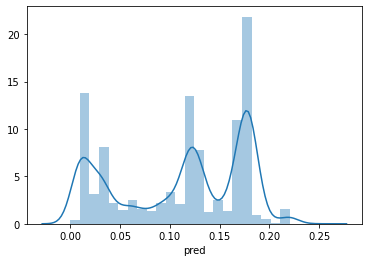

In [ ]:
sns.distplot(df_mod_copy.pred)

Se detecta que la gran cantidad de datos está entre 0% y 20 % de probabilidad de incumplimiento.

Vamos a verificar los puntos de corte en los cuantiles 33, 66 y 99

In [ ]:
print(df_mod_copy.pred.quantile(q=0.33))
print(df_mod_copy.pred.quantile(q=0.66))
print(df_mod_copy.pred.quantile(q=0.99))

0.09
0.17
0.22000000000000003


Esté método nos dice que los clientes de mayor riesgo están donde la probabilidad de incumplimiento en la primera factura sea mayor de 22 %, el cuál es muy flexible dada la distribución de los datos


En este método vamos a verificar el punto de corte para los Cuartiles

In [ ]:
df_mod_copy.pred.describe()

count   19942.00
mean        0.11
std         0.06
min         0.00
25%         0.04
50%         0.12
75%         0.17
max         0.25
Name: pred, dtype: float64

podemos denotar que el 75% de los datos la probabilidad de incumplimiento en la primera factura es < 15 %, por lo tanto esté es un criterio más adecuado para definir los puntos de corte, ***entre 0% y 4% -> Bajo Riesgo, 5% y 16% Medio Riesgo, y donde  sea > 16% es Alto riesgo***

**Describa el perfil de los clientes con un alto riegso de no pago.**

In [ ]:
df_alto_riesgo = df_mod_copy[df_mod_copy ['pred'] > 0.16]

In [ ]:
pd.options.display.float_format = "{:.2f}".format
df_alto_riesgo.describe(include='all')

,DEPARTAMENTO,TECNOL,GERENCIA,CANAL_HOMOLOGADO_MILLICON,tipo_fuerza_venta,estrato,antiguedad_meses,productos,portafolio,asesoria_factura,pedidos_peticiones,reagendamiento,asesoria_servicios,retencion,Otras,quejas_fraude,traslado,Incumplimiento_pago,pred
count,6858,6858,6858,6858,6858,6858.00,6858.00,6858,6858,6858.00,6858.00,6858.00,6858.00,6858.00,6858.00,6858.00,6858.00,6858.00,6858.00
unique,18,4,5,9,1,nan,nan,4,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,ANTIOQUIA,HFC,CONTACT,SAC,INDIRECTA,nan,nan,TO+TV+BA,Individual,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,5159,5714,6745,3244,6858,nan,nan,3051,3807,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,2.84,54.81,NaN,NaN,0.08,0.08,0.04,0.04,0.02,0.01,0.04,0.06,0.15,0.18
std,NaN,NaN,NaN,NaN,NaN,1.13,63.59,NaN,NaN,0.27,0.28,0.19,0.19,0.14,0.10,0.19,0.23,0.35,0.01
min,NaN,NaN,NaN,NaN,NaN,1.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17
25%,NaN,NaN,NaN,NaN,NaN,2.00,11.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17
50%,NaN,NaN,NaN,NaN,NaN,3.00,25.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.18
75%,NaN,NaN,NaN,NaN,NaN,3.00,70.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.18


De los clientes de riesgo alto se puede concluir que más del 50 % están en el departamento de Antioquia, la gran mayoría con Tennología HFC, y con productos TO+TV+BA y con un promedio de antiguedad de meses de 54.8, donde el 75% de los datos se concentran en una antiguedad de meses igual a 70, de igual modo todos los cliente de perfil Alto riesgo tienen tipo de fuerza indirecta.

Del mismo modo más del 50 % de los clientes en alto riesgo se encuentra en el portafolio individual


**Pérfil Medio Riesgo**

In [ ]:
df_medio_riesgo = df_mod_copy[(df_mod_copy ['pred'] >= 0.05) & (df_mod_copy ['pred'] <= 0.16) ]

In [ ]:
pd.options.display.float_format = "{:.2f}".format
df_medio_riesgo.describe(include='all')

,DEPARTAMENTO,TECNOL,GERENCIA,CANAL_HOMOLOGADO_MILLICON,tipo_fuerza_venta,estrato,antiguedad_meses,productos,portafolio,asesoria_factura,pedidos_peticiones,reagendamiento,asesoria_servicios,retencion,Otras,quejas_fraude,traslado,Incumplimiento_pago,pred
count,7804,7804,7804,7804,7804,7804.00,7804.00,7804,7804,7804.00,7804.00,7804.00,7804.00,7804.00,7804.00,7804.00,7804.00,7804.00,7804.00
unique,22,4,6,11,2,nan,nan,7,3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,ANTIOQUIA,HFC,FVD,TIENDAS,INDIRECTA,nan,nan,TO+TV+BA,Trio,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,3101,5932,2911,2693,7400,nan,nan,4470,4470,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,2.83,23.72,NaN,NaN,0.03,0.02,0.01,0.01,0.01,0.00,0.02,0.04,0.17,0.11
std,NaN,NaN,NaN,NaN,NaN,1.03,45.23,NaN,NaN,0.18,0.16,0.09,0.12,0.09,0.05,0.15,0.19,0.37,0.03
min,NaN,NaN,NaN,NaN,NaN,1.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05
25%,NaN,NaN,NaN,NaN,NaN,2.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10
50%,NaN,NaN,NaN,NaN,NaN,3.00,7.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12
75%,NaN,NaN,NaN,NaN,NaN,3.00,19.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.13


In [ ]:
df_bajo_riesgo = df_mod_copy[df_mod_copy ['pred'] < 0.05]

In [ ]:
pd.options.display.float_format = "{:.2f}".format
df_bajo_riesgo.describe(include='all')

,DEPARTAMENTO,TECNOL,GERENCIA,CANAL_HOMOLOGADO_MILLICON,tipo_fuerza_venta,estrato,antiguedad_meses,productos,portafolio,asesoria_factura,pedidos_peticiones,reagendamiento,asesoria_servicios,retencion,Otras,quejas_fraude,traslado,Incumplimiento_pago,pred
count,5280,5280,5280,5280,5280,5280.00,5280.00,5280,5280,5280.00,5280.00,5280.00,5280.00,5280.00,5280.00,5280.00,5280.00,5280.00,5280.00
unique,18,4,6,11,2,nan,nan,7,3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,ANTIOQUIA,HFC,CONTACT,SAC,INDIRECTA,nan,nan,TO+BA,Duo,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,3395,3982,2289,1077,4635,nan,nan,2174,4727,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,2.69,48.04,NaN,NaN,0.06,0.05,0.02,0.03,0.01,0.01,0.02,0.05,0.11,0.02
std,NaN,NaN,NaN,NaN,NaN,1.04,61.73,NaN,NaN,0.24,0.22,0.14,0.16,0.11,0.07,0.13,0.22,0.31,0.01
min,NaN,NaN,NaN,NaN,NaN,1.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,NaN,NaN,NaN,NaN,NaN,2.00,7.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
50%,NaN,NaN,NaN,NaN,NaN,3.00,16.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
75%,NaN,NaN,NaN,NaN,NaN,3.00,61.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03


**sugerencias  al equipo de cobranzas de acuerdo al análisis de la información del modelo.**

In [ ]:
df_mod.columns

Index(['DEPARTAMENTO', 'TECNOL', 'GERENCIA', 'CANAL_HOMOLOGADO_MILLICON',
       'tipo_fuerza_venta', 'estrato', 'antiguedad_meses', 'productos',
       'portafolio', 'asesoria_factura', 'pedidos_peticiones',
       'reagendamiento', 'asesoria_servicios', 'retencion', 'Otras',
       'quejas_fraude', 'traslado', 'Incumplimiento_pago'],
      dtype='object')

In [ ]:
rfc.feature_importances_

array([0.1206656 , 0.034941  , 0.04589053, 0.08421568, 0.00920263,
       0.12511291, 0.35787514, 0.05789299, 0.08596321, 0.01545343,
       0.01248422, 0.0061448 , 0.00827867, 0.00493707, 0.00206044,
       0.01307972, 0.01580197])

Cómo sugerencia se daría darle un mayor peso en el análisis a la variable antiguedad en meses ya que tiene una gran importancia en el modelo, como lo habiamos identificado en la matriz de correlación.

Del mismo modo se sugiere prestarle atención al tipo de Tecnología de HFC.

In [ ]:
df_mod_copy.to_excel('Mi unidad\Base_modelo_prob.xlsx', sheet_name='Base_modelo_prob')

In [ ]:
from google.colab import files
files.download('Base_modelo_prob.xlsx')